In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

%matplotlib inline

## Discrete updating algorithm

### Continuous time definitions
$y_{\textrm{ref}}$ : Reference level

$y_{\textrm{SAM}}$ : Output of SAM

$y_{\textrm{MPM}}$ : Output of of MPM

$I_{\textrm{SAM}}$ : Input to SAM

$I_{\textrm{MPM}}$ : Input to MPM


### Translation into discrete time
$i$ will index *time-points* and *intervals*

$t_p^i$ : time of $i$th production

$t_s^i$ : time of $i$th stimulus

$\textrm{ISI}^i$ = $t_s^{i+1} - t_s^i$

$\textrm{IPI}^i$ = $t_p^{i+1} - t_p^i$

$y_{\textrm{SAM}}^i=I_{\textrm{SAM}}^i*\textrm{ISI}^i$

$I_{\textrm{SAM}}^{i+1}=I_{\textrm{SAM}}^i+\beta(y_{\textrm{ref}}-y_{\textrm{SAM}}^i)$

$I_{\textrm{MPM}}^{i+1} = I_{\textrm{SAM}}^{i+1} + \alpha(y_{\textrm{out}}^i-y_{\textrm{MPM}}^i)$

$\textrm{IPI}^i=y_{\textrm{ref}}/I_{\textrm{MPM}}$

$t_p^{i+1}=t_p^i+\textrm{IPI}^i$

By definition $y_{\textrm{MPM}}^i=y_{\textrm{ref}}$ (output of $y_{\textrm{MPM}}$ at ith production)

The value of $y_{\textrm{out}}^i$ represents the output of the SAM at the time of the $i$th production. During synchronization that will be:

$y_{\textrm{out}}^i = I_{\textrm{SAM}}^i*(t_p^i-t_s^{i-1})$

During continuation:

$y_{\textrm{out}}^i = y_{\textrm{SAM}}^\infty$

with $y_{\textrm{SAM}}^\infty$ representing the terminal output of the SAM module.

In [183]:
# Definitions
def I_s_update(I_s_in,beta,y_ref,y_s):
    I_s_out = I_s_in + beta*(y_ref - y_s)
    
    return I_s_out

def I_p_update(I_s,alpha,y_p,y_out):
    I_p_out = I_s + alpha*(y_out-y_p)
    
    return I_p_out

def discreteAlgorithm_multiple(ISI, n, beta=0.5, alpha=0.1, y_ref=1, 
                               I_s_init=0.8, y_s_infty=1.5, sigma=0):
    '''Perform multiple simulations of the discrete algorithm
    Returns: an array of size n x T'''
    IPIs = []
    for i in range(n):
        _, t_p, IPI, _, _, _ = discreteAlgorithm(ISI, beta, alpha, y_ref, I_s_init,
                                                        y_s_infty, sigma)
        #print('tp and IPI')
        #print(t_p)
        #print(IPI)
        #print(np.diff(t_p))
        IPI_noise = np.diff(t_p)
        IPIs.append(IPI_noise)
        
    return np.array(IPIs)
    


def discreteAlgorithm(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=0.8, y_s_infty=1.5, sigma=0):

    t_s = np.zeros(len(ISI)+1)
    t_s[1:len(ISI)+1] = np.cumsum(ISI)
    IPI = np.zeros((len(t_s))-1)
    t_p = np.zeros((len(t_s)))
    I_s = np.zeros((len(t_s)))
    I_p = np.zeros((len(t_s)))
    y_s = np.zeros((len(t_s)))
    I_p[0] = I_s_init
    I_s[0] = I_s_init

    for i in range(len(ISI)):
        
        IPI[i] = y_ref/I_p[i]
        if i > 0:
            noise = np.random.randn() * sigma
            
            t_p[i+1] = t_p[i] + IPI[i] + noise
            #print(t_p)
            #print(IPI)
        else:
            #print(i, 'here2')
            t_p[i+1] = IPI[i] + np.random.randn() * sigma
        
        if np.isnan(ISI[i]):
            y_s[i] = y_s_infty
            I_s[i+1] = I_s[i]
        else:
            y_s[i] = I_s[i]*ISI[i]
            I_s[i+1] = I_s_update(I_s[i],beta,y_ref,y_s[i])

        
        if np.isnan(ISI[i]):
            y_out = y_s_infty
        else:
            if i == 0:
                y_out = y_ref
            else:
                y_out = I_s[i]*(t_p[i]-t_s[i-1])
            #print(i,y_out)

        # Standard code for algorithm, implementing integration of differences over time
        I_p[i+1] = I_p_update(I_s[i+1],alpha,y_ref,y_out)
        
        # Code that does not integrate differences over time
        #if np.isnan(t_s[i]):
        #    I_p[i+1] = I_p_update(I_s[i+1],alpha,t_p[i],t_p[i]+0.4)
        #else:       
        #    I_p[i+1] = I_p_update(I_s[i+1],alpha,t_p[i],t_s[i])
        
        #print(t_s[i],t_p[i],IPI[i])
    #print(t_p)
    return t_s, t_p, IPI, I_s, I_p, y_s

In [184]:
discreteAlgorithm_multiple([0.5] * 4 + [np.nan] * 7, 3, sigma=0.1)

array([[1.41789359, 0.78816417, 0.88391979, 0.53802973, 0.5479366 ,
        0.48415039, 0.67427167, 0.54014986, 0.69136376, 0.67331268,
        0.60012263],
       [1.40584152, 0.80702663, 0.86830884, 0.72611892, 0.55138525,
        0.7761696 , 0.486693  , 0.70599881, 0.54639454, 0.43254876,
        0.82197112],
       [1.19649422, 0.90263845, 0.697884  , 0.69500175, 0.68488188,
        0.63814907, 0.6365559 , 0.75555886, 0.76463994, 0.50890232,
        0.54789062]])

## Synchronization to a constant ISI

In [3]:
# Simple synchronization
ISI = [0.4] * 500
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.2, alpha=0.1, y_ref=1, I_s_init=1/0.35, sigma=0)

#for i in range(len(t_s)):
#    print(t_s[i],t_p[i],IPI[i])

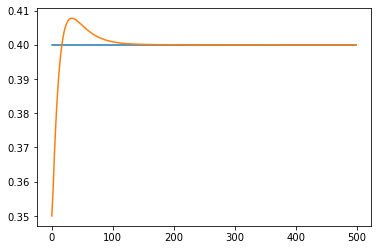

In [4]:
plt.plot(ISI)
plt.plot(IPI)

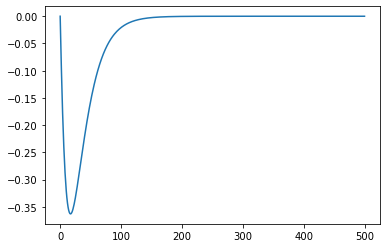

In [5]:
plt.plot(t_p-t_s)

## Step Change

In [6]:
# Step change
ISI = np.concatenate((0.80*np.ones(100),1.00*np.ones(30)))
del t_p
del t_s
del IPI
del I_s
del I_p
del y_s
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=1/0.8, sigma=0)

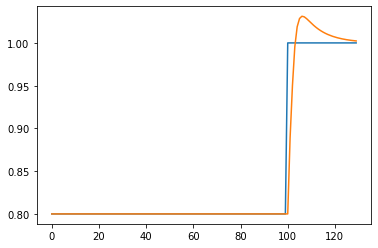

In [7]:
plt.plot(ISI)
plt.plot(IPI)

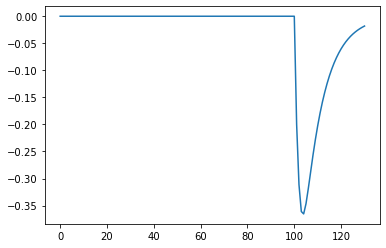

In [8]:
plt.plot(t_p-t_s)

## Phase shift

In [9]:
# Phase shift
ISI = np.concatenate((0.80*np.ones(50),0.9*np.ones(1),0.80*np.ones(50)))
del t_p
del t_s
del IPI
del I_s
del I_p
del y_s
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.7, alpha=0.1, y_ref=1, I_s_init=1/0.8, sigma=0)

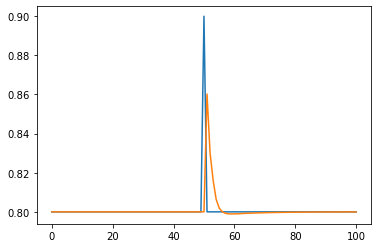

In [10]:
plt.plot(ISI)
plt.plot(IPI)

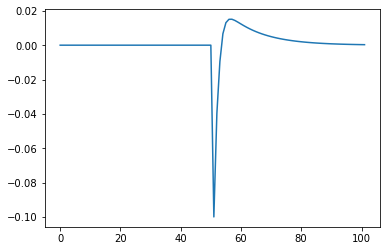

In [11]:
plt.plot(t_p-t_s)

## Stimulus jitter

In [12]:
# Stimulus jitter
ISI = np.concatenate((0.80*np.ones(50),0.9*np.ones(1), 0.7*np.ones(1), 0.80*np.ones(49)))
del t_p
del t_s
del IPI
del I_s
del I_p
del y_s
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.7, alpha=0.1, y_ref=1, I_s_init=1/0.8, sigma=0)

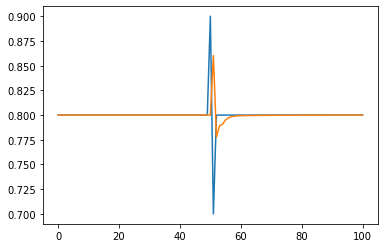

In [13]:
plt.plot(ISI)
plt.plot(IPI)

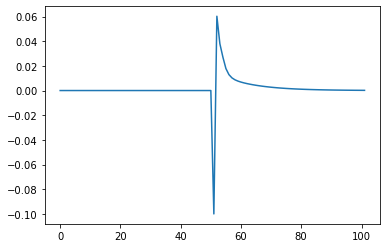

In [14]:
plt.plot(t_p-t_s)

## 1-2-Go, 1-2-3-Go

In [15]:
def simulate_123Go(nstages=3,beta=0.75,alpha=0.0,ISI0=0.8,y_ref=1,ISImin=0.600,ISImax=1.000,number=5, sigma=0):
    # 1-2-Go, 1-2-3-Go
    ISIs = np.linspace(ISImin,ISImax,num=number)
    ISI_list = np.nan*np.ones((len(ISIs),nstages))
    IPI_list = np.nan*np.ones((len(ISIs),nstages))
    t_s_list = []
    t_p_list = []
    for i in range(len(ISIs)):
        ISI_list[i,:] = ISIs[i]*np.ones(nstages)
        ISI = ISI_list[i,:]
        t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=beta, alpha=alpha, 
                                                         y_ref=y_ref, I_s_init=1/ISI0,
                                                        sigma=sigma)

        t_s_list.append(t_s)
        t_p_list.append(t_p)
        IPI_list[i,:] = IPI
    
    return IPI_list, ISIs

IPI_list, ISIs = simulate_123Go()

In [16]:
print(IPI_list.shape)
tempISIs = np.matlib.repmat(ISIs,3,1)
sqErrs = np.square(IPI_list - np.transpose(tempISIs))
sqBIAS = sqErrs.sum(axis=0)/len(ISIs)
print(sqBIAS)

(5, 3)
[0.02       0.00315929 0.0006393 ]


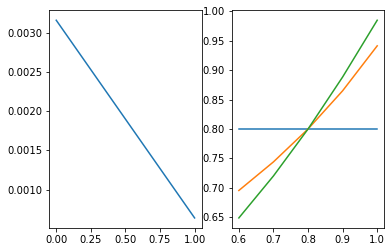

In [17]:
plt.subplot(121)
plt.plot(sqBIAS[1:3])

plt.subplot(122)
plt.plot(np.transpose(tempISIs),IPI_list)

## Synchronization/continuation

In [18]:
# Synchronization/continuation
ISIs = np.linspace(0.550,0.817,num=5)
print(ISIs)
ISI_list = np.nan*np.ones((len(ISIs),12))
IPI_list = np.nan*np.ones((len(ISIs),12))
t_s_list = []
t_p_list = []
for i in range(len(ISIs)):
    ISI_list[i,:] = np.concatenate((ISIs[i]*np.ones(4),np.nan*np.ones(8)))
    del t_p
    del t_s
    del IPI
    del I_s
    del I_p
    del y_s
    ISI = ISI_list[i,:]
    t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.75, alpha=0.1, y_ref=1, 
                                                     I_s_init=1/0.6835, y_s_infty=1.5,
                                                    sigma=0)
    
    t_s_list.append(t_s)
    t_p_list.append(t_p)
    IPI_list[i,:] = IPI

[0.55    0.61675 0.6835  0.75025 0.817  ]


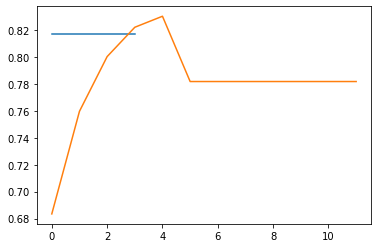

In [19]:
plt.plot(ISI)
plt.plot(IPI)

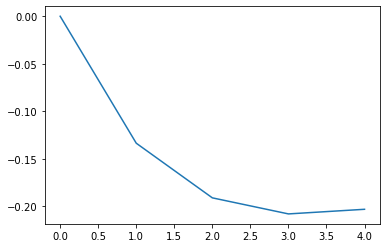

In [20]:
plt.plot(t_p-t_s)

In [21]:
tempISIs = np.matlib.repmat(ISIs,12,1)
sqErrs = np.square(IPI_list - np.transpose(tempISIs))
sqBIAS = sqErrs.sum(axis=0)/len(ISIs)
print(sqBIAS)

[8.91112500e-03 2.09892614e-03 3.95389908e-04 4.58888671e-05
 3.99369634e-05 5.65980556e-04 5.65980556e-04 5.65980556e-04
 5.65980556e-04 5.65980556e-04 5.65980556e-04 5.65980556e-04]


(12, 5)


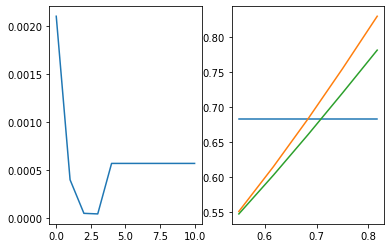

In [22]:
plt.subplot(121)
plt.plot(sqBIAS[1:12])

plt.subplot(122)
print(tempISIs.shape)
plt.plot(np.transpose(tempISIs[(0,4,10),:]),IPI_list[:,(0,4,10)])

### Fit to behavior

#### Synchronization/continuation

In [205]:
import scipy.io
import glob

def find_bias_arr(filename, tmax):
    '''filename: SynCon_ITIs file name
    tmax: max number of taps to consider
    
    Returns: the bias array, tmax x number of intervals in prior'''
    data = scipy.io.loadmat(filename)
    durs = data['durs'].flatten()
    splits = data['allDur_splits']
    IPI_mean = data['allDur_mean'][0]
    
    Bias = np.zeros((tmax, 5))

    for i in range(len(IPI_mean)):
        IPI_single = IPI_mean[i].flatten()[:tmax]
        bias_single = IPI_single - durs[i]
        Bias[:,i] = bias_single
    
    return Bias

def plot_subject_ts_tp(filename):
    bias_arr = find_bias_arr(filename, 20)
    std_arr = find_std_arr(filename, 20)
    data = scipy.io.loadmat(filename)
    durs = data['durs'].flatten()

    # Plot ts-tp dependence (subject)
    bias_first = bias_arr[0,:]
    std_first = std_arr[0,:]
    bias_third = bias_arr[2,:]
    std_third = std_arr[2,:]
    bias_fifth = bias_arr[4,:]
    std_fifth = std_arr[4,:]

    plt.errorbar(durs, durs + bias_third, std_third)
    plt.errorbar(durs, durs + bias_fifth, std_fifth)
    plt.plot(durs, durs, '--')

def find_std_arr(filename, tmax):
    '''filename: SynCon_ITIs file name
    tmax: max number of taps to consider
    
    Returns: the bias array, tmax x number of intervals in prior'''
    data = scipy.io.loadmat(filename)
    durs = data['durs'].flatten()
    splits = data['allDur_splits']
    IPI_std = data['allDur_std'][0]
    
    STD = np.zeros((tmax, 5))

    for i in range(len(IPI_std)):
        std_single = IPI_std[i].flatten()[:tmax]
        STD[:,i] = std_single
    
    return STD
    
def simulate_sync_cont_bias(ISIs, ntrials, beta, alpha, ISI0, sigma):
    meanITIs = []

    for i in range(len(ISIs)):
        ISI_list = np.concatenate((ISIs[i]*np.ones(4),np.nan*np.ones(17)))        
        IPI_lst = discreteAlgorithm_multiple(ISI_list, ntrials, beta, alpha, y_ref=1, 
                               I_s_init=ISI0, y_s_infty=1.5, sigma=sigma)
        #print(IPI_lst)
        meanIPI = np.mean(IPI_lst, axis=0)
        meanITIs.append(meanIPI)
        
    meanITIs = np.array(meanITIs)
    bias_individual = meanITIs - ISIs[:,np.newaxis]
    bias_all_sim = np.mean(bias_individual**2, axis=0)
    return np.sqrt(bias_all_sim)[1:]

def minimizer_noise(filename,ISIs,nsamples,betaRange,alphaRange,ISI0Range,sigma):
    bias_arr = find_bias_arr(filename, 20)
    betas = np.random.uniform(low=betaRange[0], high=betaRange[1], size=nsamples)
    alphas = np.random.uniform(low=alphaRange[0], high=alphaRange[1], size=nsamples)
    ISI0s = np.random.uniform(low=ISI0Range[0], high=ISI0Range[1], size=nsamples)
    mse = np.nan*np.ones((nsamples,1))
    
    ntrials = 21
    for j in range(nsamples):
        biasSim = simulate_sync_cont_bias(ISIs, ntrials, betas[j], 
                                          alphas[j], 1/ISI0s[j], sigma)
        biasObs = np.sqrt( np.nanmean(bias_arr**2,axis=1) )
        mse[j] = np.nanmean((biasObs - biasSim)**2)
        
    id = np.argmin(mse)
    print(id)
    beta = betas[id]
    alpha = alphas[id]
    ISI0 = ISI0s[id]
    return beta, alpha, ISI0

def minimizer(filename,ISIs,nsamples,betaRange,alphaRange,ISI0Range):
    bias_arr = find_bias_arr(filename, 20)
    
    betas = np.random.uniform(low=betaRange[0], high=betaRange[1], size=nsamples)
    alphas = np.random.uniform(low=alphaRange[0], high=alphaRange[1], size=nsamples)
    ISI0s = np.random.uniform(low=ISI0Range[0], high=ISI0Range[1], size=nsamples)
    mse = np.nan*np.ones((nsamples,1))
    for j in range(nsamples):
        ISI_list = np.nan*np.ones((len(ISIs),21))
        ISI_list2 = np.nan*np.ones((len(ISIs),21))
        IPI_list = np.nan*np.ones((len(ISIs),21))
        t_s_list = []
        t_p_list = []
        for i in range(len(ISIs)):
            ISI_list[i,:] = np.concatenate((ISIs[i]*np.ones(4),np.nan*np.ones(17)))
            ISI_list2[i,:] = ISIs[i]*np.ones(21)
            ISI = ISI_list[i,:]
            _, _, IPI, _, _, _ = discreteAlgorithm(ISI, beta=betas[j], alpha=alphas[j], y_ref=1,
                                                             I_s_init=1/ISI0s[j], y_s_infty=1.5, sigma=0)
            IPI_list[i,:] = IPI
            
        biasSim = np.sqrt( np.nanmean((IPI_list[:,1:]-ISI_list2[:,1:])**2,axis=0) )
        biasObs = np.sqrt( np.nanmean(bias_arr**2,axis=1) )
        mse[j] = np.nanmean((biasObs - biasSim)**2)
           
    id = np.argmin(mse)
    print(id)
    beta = betas[id]
    alpha = alphas[id]
    ISI0 = ISI0s[id]
    return beta, alpha, ISI0

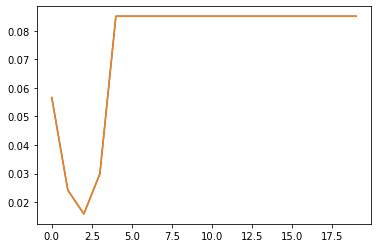

In [91]:
ISI_list = np.nan*np.ones((len(ISIs),21))
ISI_list2 = np.nan*np.ones((len(ISIs),21))
IPI_list = np.nan*np.ones((len(ISIs),21))
t_s_list = []
t_p_list = []
for i in range(len(ISIs)):
    ISI_list[i,:] = np.concatenate((ISIs[i]*np.ones(4),np.nan*np.ones(17)))
    ISI_list2[i,:] = ISIs[i]*np.ones(21)
    ISI = ISI_list[i,:]
    #print(ISI)
    _, _, IPI, _, _, _ = discreteAlgorithm(ISI, beta=0.6, alpha=0.4, y_ref=1,
                                                     I_s_init=1/0.7, y_s_infty=1.5, sigma=0)
    IPI_list[i,:] = IPI


biasSim = np.sqrt( np.nanmean((IPI_list[:,1:]-ISI_list2[:,1:])**2,axis=0) )
plt.plot(bias2[1:])
plt.plot(biasSim)

In [185]:
ISIs = np.linspace(0.550,0.817,num=5)
dirlst = glob.glob('C:\\Users\\Le\\Dropbox (MIT)\\Jazayeri\\SyncContData\\*_2_*ITIs.mat')
#dirlst = glob.glob('/Users/swe/Dropbox (MIT)/CircuitModel/Data/*_2_*ITIs.mat')
filename = dirlst[4] #'/Users/swe/Dropbox (MIT)/CircuitModel/Data/FK_2_20170721_SynCon_ITIs.mat'
print(filename)
beta, alpha, ISI0 = minimizer(filename, ISIs,nsamples=1000, betaRange=[0,0.8], alphaRange=[0,0.8], ISI0Range=[0.5,0.9])


C:\Users\Le\Dropbox (MIT)\Jazayeri\SyncContData\FK_2_20170721_SynCon_ITIs.mat
775


In [206]:
BETAS = np.zeros((len(dirlst),1))
ALPHAS = np.zeros((len(dirlst),1))
ISIinits = np.zeros((len(dirlst),1))
for filei in range(len(dirlst)):
    filename = dirlst[filei] #'/Users/swe/Dropbox (MIT)/CircuitModel/Data/FK_2_20170721_SynCon_ITIs.mat'
    print(filename)
    beta, alpha, ISI0 = minimizer_noise(filename, ISIs,nsamples=1000, 
                                        betaRange=[0,0.8], alphaRange=[0,0.8], 
                                        ISI0Range=[0.5,0.9], sigma=0.06)
    
    BETAS[filei] = beta
    ALPHAS[filei] = alpha
    ISIinits[filei] = ISI0

C:\Users\Le\Dropbox (MIT)\Jazayeri\SyncContData\AL_2_20170719_SynCon_ITIs.mat
998
C:\Users\Le\Dropbox (MIT)\Jazayeri\SyncContData\BG_2_20170719_SynCon_ITIs.mat
624
C:\Users\Le\Dropbox (MIT)\Jazayeri\SyncContData\CA_2_20170719_SynCon_ITIs.mat
304
C:\Users\Le\Dropbox (MIT)\Jazayeri\SyncContData\ER_2_20170718_SynCon_ITIs.mat
27
C:\Users\Le\Dropbox (MIT)\Jazayeri\SyncContData\FK_2_20170721_SynCon_ITIs.mat
699
C:\Users\Le\Dropbox (MIT)\Jazayeri\SyncContData\KL_2_20170721_SynCon_ITIs.mat
247
C:\Users\Le\Dropbox (MIT)\Jazayeri\SyncContData\MW_2_20170720_SynCon_ITIs.mat
674
C:\Users\Le\Dropbox (MIT)\Jazayeri\SyncContData\RC_2_20170721_SynCon_ITIs.mat
876


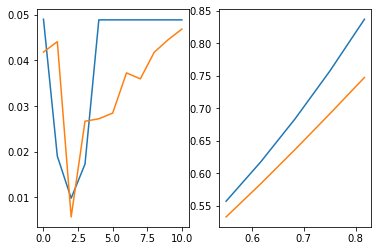

In [187]:
ISI_list = np.nan*np.ones((len(ISIs),12))
IPI_list = np.nan*np.ones((len(ISIs),12))
t_s_list = []
t_p_list = []
for i in range(len(ISIs)):
    ISI_list[i,:] = np.concatenate((ISIs[i]*np.ones(4),np.nan*np.ones(8)))
    del t_p
    del t_s
    del IPI
    del I_s
    del I_p
    del y_s
    ISI = ISI_list[i,:]
    t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=beta, alpha=alpha, y_ref=1, 
                                                     I_s_init=1/ISI0, y_s_infty=1.5,
                                                    sigma=0)
    
    t_s_list.append(t_s)
    t_p_list.append(t_p)
    IPI_list[i,:] = IPI


bias_arr = find_bias_arr(filename, 20)
biasObs = np.sqrt(np.nanmean(bias_arr**2,axis=1))
tempISIs = np.matlib.repmat(ISIs,12,1)
sqErrs = np.square(IPI_list - np.transpose(tempISIs))
sqBIAS = sqErrs.sum(axis=0)/len(ISIs)

plt.subplot(121)
plt.plot(np.sqrt(sqBIAS[1:12]))
plt.plot(biasObs[0:11])

plt.subplot(122)
plt.plot(np.transpose(tempISIs[(3,5),:]),IPI_list[:,(3,5)])
#plot_subject_ts_tp(filename)

With the fitted values, we now perform the simulations.

C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


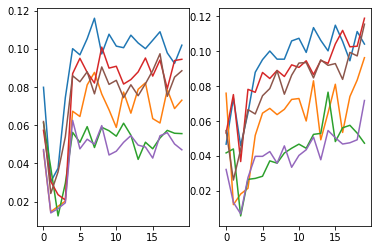

In [237]:
plotlst = [0,3,4,5,6,7]

Bias_sim_mean = np.zeros((6, 20))



for idx, filei in enumerate(plotlst):
    # Perform the simulation
    ISI_list = np.nan*np.ones((len(ISIs),21))
    IPI_list = np.nan*np.ones((len(ISIs),21))
    t_s_list = []
    t_p_list = []
    
    beta = BETAS[filei, 0]
    alpha = ALPHAS[filei, 0]
    ISI0 = ISIinits[filei, 0]
    filename = dirlst[filei]


    bias_arr = find_bias_arr(filename, 20)
    biasObs = np.sqrt(np.nanmean(bias_arr**2,axis=1))


    biasModel = simulate_sync_cont_bias(ISIs, ntrials=21, beta=beta, 
                                        alpha=alpha, ISI0=1/ISI0, sigma=0.06)
    plt.subplot(121)
    plt.plot(biasModel)
    
    plt.subplot(122)
    plt.plot(biasObs)

    Bias_sim_mean[idx, :] = biasModel * 1000
    #plt.plot(np.transpose(tempISIs[(3,5),:]),IPI_list[:,(3,5)])
    #plot_subject_ts_tp(filename)

In [238]:
scipy.io.savemat('PlotTools/sync_cont_figure_algorithmic_circuit_012120c.mat', {'alphasummary': ALPHAS,
                                                             'Isummary': ISIinits,
                                                             'Ksummary': BETAS,
                                                             'Bias_sim_mean': Bias_sim_mean})

In [235]:
# For figure 8b & 8c
plotlst = [0,3,4,5,6,7]

meanITI_model = []
stdITI_model = []

for idx, filei in enumerate(plotlst):
    # Perform the simulation
    beta = BETAS[filei, 0]
    alpha = ALPHAS[filei, 0]
    ISI0 = ISIinits[filei, 0]
    filename = dirlst[filei]
    sigma = 0.06
    
    meanITIs = []
    stdITIs = []

    for i in range(len(ISIs)):
        ISI_list = np.concatenate((ISIs[i]*np.ones(4),np.nan*np.ones(17)))        
        IPI_lst = discreteAlgorithm_multiple(ISI_list, ntrials, beta, alpha, y_ref=1, 
                               I_s_init=1/ISI0, y_s_infty=1.5, sigma=sigma)
        #print(IPI_lst)
        meanIPI = np.mean(IPI_lst, axis=0)
        stdIPI = np.std(IPI_lst, axis=0)
        meanITIs.append(meanIPI)
        stdITIs.append(stdIPI)
        
    meanITI_model.append(np.array(meanITIs)[:,1:] * 1000)
    stdITI_model.append(np.array(stdITIs)[:,1:] * 1000)

In [236]:
scipy.io.savemat('PlotTools/subject_ts_tp_sync_cont_discreteAlgo_012220.mat',
                {'durs': ISIs, 'meanITI_model': meanITI_model, 
                 'stdITI_model': stdITI_model})

#### 1-2-Go/1-2-3-Go

In [29]:
def get_time_lst(nstages, beta, alpha, ISI0):
    '''Simulate and return the array of times of threshold crossing'''
    IPI_list, ISIs = simulate_123Go(nstages=nstages,beta=beta,alpha=alpha,ISI0=ISI0)
    times = 1000*IPI_list[:,-2:-1]

    return times

def do_beta_alpha_ISI0_fitting(subject_file, nsamples, betalow, betahigh, alphalow, alphahigh, ISI0low, ISI0high,
                 print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - nsamples: number of random (beta,alpha,ISI0) combinations to sample
    - betalow, betahigh, alphalow, alphahigh, ISI0low, ISI0high: ranges of beta, alpha, and ISI0 for sampling
    
    Outputs:
    beta, alpha, ISI0: the optimal combination to minimize the mse between the mean simulated times
    and the mean behavioral times of the subject'''
    #print('sigmaval = ', sigmaval)
    betalst = np.random.uniform(low=betalow, high=betahigh, size=nsamples)
    alphalst = np.random.uniform(low=alphalow, high=alphahigh, size=nsamples)
    ISI0lst = np.random.uniform(low=ISI0low, high=ISI0high, size=nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        ISI0val = ISI0lst[k]
        betaval = betalst[k]
        alphaval = alphalst[k]

        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        prod_time_lst = get_time_lst(nstages=2, beta=betaval, alpha=alphaval, ISI0=ISI0val)

        #1,2,3,Go simulation
        prod_time_lst2 = get_time_lst(nstages=3, beta=betaval, alpha=alphaval, ISI0=ISI0val)

        # Continue if there is a nan   
        error1 = (np.transpose(prod_time_lst) - target_time1) ** 2
        error2 = (np.transpose(prod_time_lst2) - target_time2) ** 2
        
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
        # Error function to minimize
            error = np.sum((np.transpose(prod_time_lst) - target_time1) ** 2) +\
                    np.sum((np.transpose(prod_time_lst2) - target_time2) ** 2)
        errorlst.append(error)

        #if k % print_every == 0: # Print every 10 lines
        #    print('    alpha = %f, beta = %f, ISI0 = %f, error = %f' %(alphaval, betaval, ISI0val, error))
    
    # Find the optimal
    plt.scatter(betalst,alphalst,c=np.sqrt(errorlst))
    idx = np.argmin(errorlst)
    return betalst[idx], alphalst[idx], ISI0lst[idx]

In [30]:
dirlst

['C:\\Users\\Le\\Dropbox (MIT)\\Jazayeri\\SyncContData\\AL_2_20170719_SynCon_ITIs.mat',
 'C:\\Users\\Le\\Dropbox (MIT)\\Jazayeri\\SyncContData\\BG_2_20170719_SynCon_ITIs.mat',
 'C:\\Users\\Le\\Dropbox (MIT)\\Jazayeri\\SyncContData\\CA_2_20170719_SynCon_ITIs.mat',
 'C:\\Users\\Le\\Dropbox (MIT)\\Jazayeri\\SyncContData\\ER_2_20170718_SynCon_ITIs.mat',
 'C:\\Users\\Le\\Dropbox (MIT)\\Jazayeri\\SyncContData\\FK_2_20170721_SynCon_ITIs.mat',
 'C:\\Users\\Le\\Dropbox (MIT)\\Jazayeri\\SyncContData\\KL_2_20170721_SynCon_ITIs.mat',
 'C:\\Users\\Le\\Dropbox (MIT)\\Jazayeri\\SyncContData\\MW_2_20170720_SynCon_ITIs.mat',
 'C:\\Users\\Le\\Dropbox (MIT)\\Jazayeri\\SyncContData\\RC_2_20170721_SynCon_ITIs.mat']

C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\VD_EKF_ObsAct0_20171105.mat


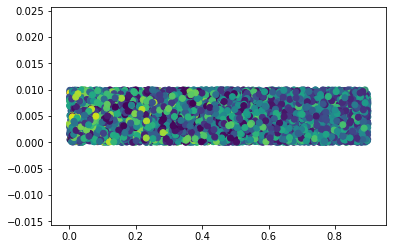

In [31]:
dirlst = glob.glob('C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data/*_EKF_*.mat')
#dirlst = glob.glob('/Users/swe/Dropbox (MIT)/CircuitModel/Data/*_EKF_*.mat')
filename = dirlst[-2]
print(filename)
beta, alpha, ISI0 = do_beta_alpha_ISI0_fitting(filename, nsamples=10000, betalow=0.0, betahigh=0.9, alphalow=0, alphahigh=0.01, ISI0low=0.500, ISI0high=1.100)


C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\VD_EKF_ObsAct0_20171105.mat
0.004910655105042634 0.2776764698203417 0.7767506691733004


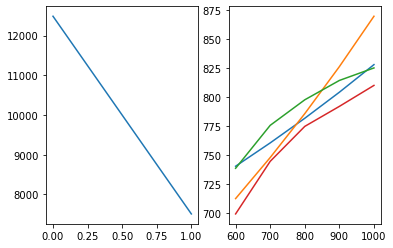

In [33]:
print(filename)
swedata = scipy.io.loadmat(filename)
mtp_in = swedata['mtp_in']


print(alpha,beta,ISI0)
IPI_list, ISIs = simulate_123Go(nstages=3,beta=beta,alpha=alpha,ISI0=ISI0)

tempISIs = np.matlib.repmat(1000*ISIs,3,1)
sqErrs = np.square(1000*IPI_list - np.transpose(tempISIs))
sqBIAS = sqErrs.sum(axis=0)/len(ISIs)

plt.subplot(121)
plt.plot(sqBIAS[1:3])

plt.subplot(122)
plt.plot(np.transpose(tempISIs[:2,:]),1000*IPI_list[:,1:3])
plt.plot(np.transpose(tempISIs[:2,:]),mtp_in)

C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\CV_EKF_ObsAct0_20171105.mat
C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\GB_EKF_ObsAct0_20171105.mat
C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\LB_EKF_ObsAct0_20171105.mat
C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\PG_EKF_ObsAct0_20171105.mat
C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\SM_EKF_ObsAct0_20171105.mat
C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\SWE_EKF_ObsAct0_20171105.mat
C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\TA_EKF_ObsAct0_20171105.mat
C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\VD_EKF_ObsAct0_20171105.mat
C:/Users/Le/Dropbox (MIT)/Jazayeri/CircuitModel/Data\VR_EKF_ObsAct0_20171105.mat


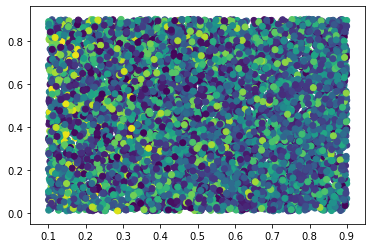

In [34]:
BETAS = np.zeros((len(dirlst),1))
ALPHAS = np.zeros((len(dirlst),1))
ISIinits = np.zeros((len(dirlst),1))
IPImodel = np.nan*np.ones((5,2,len(dirlst)))
IPIsubjects = np.nan*np.ones((5,2,len(dirlst)))
IPIsubjects_std = np.nan*np.ones((5,2,len(dirlst)))
for filei in range(len(dirlst)):
    filename = dirlst[filei] #'/Users/swe/Dropbox (MIT)/CircuitModel/Data/FK_2_20170721_SynCon_ITIs.mat'
    print(filename)
    swedata = scipy.io.loadmat(filename)
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']
    beta, alpha, ISI0 = do_beta_alpha_ISI0_fitting(filename, nsamples=1000, betalow=0.1, betahigh=0.9, alphalow=0.01, alphahigh=0.9, ISI0low=0.600, ISI0high=1.000)
    
    BETAS[filei] = beta
    ALPHAS[filei] = alpha
    ISIinits[filei] = ISI0
    
    IPI_list, ISIs = simulate_123Go(nstages=3,beta=beta,alpha=alpha,ISI0=ISI0)
    
    IPImodel[:,:,filei] = IPI_list[:,1:3]
    IPIsubjects[:,:,filei] = mtp_in
    IPIsubjects_std[:,:,filei] = stdtp_in

In [ ]:
print(IPImodel[:,:,0],BETAS[0])

In [ ]:
scipy.io.savemat('/Users/swe/Dropbox (MIT)/CircuitModel/ModelResults/discreteAlgorithm_123Go.mat', 
                 {'IPIsubjects': IPIsubjects, 'IPIsubjects_std': IPIsubjects_std,
                 'IPImodel': IPImodel, 'BETAS': BETAS,
                 'ALPHAS': ALPHAS, 'INIinits': ISIinits})